In [49]:
import sys
!{sys.executable} -m pip install --user yfinance matplotlib pandas numpy

Looking in links: /usr/share/pip-wheels


In [121]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Step 1: Get Data

In [122]:
def get_data(ticker, start, end):
   # Get daily stock data from Yahoo Finance.
    
    df = yf.download(ticker, start=start, end=end)
    df.dropna(inplace=True)
    return df

Step 2: Calculate Returns and Z-Score

In [123]:
def compute_returns_zscore(df, lookback=10):
    df = df.copy()  

    df['Return'] = df['Close'].pct_change()  
    # Calculate daily returns as the percentage change in the closing price.
    # This shows how much the stock moved each day.

    rolling_mean = df['Return'].rolling(lookback).mean()  
    # Calculate the rolling average of returns over the past lookback days.
    # This tells us the typical return during this window.

    rolling_std = df['Return'].rolling(lookback).std()  
    # Calculate the rolling standard deviation of returns over the past lookback days.
    # Shows how much returns vary during this window.

    df['Zscore'] = (df['Return'] - rolling_mean) / rolling_std  
    # Compute the Z-score: how far today's return is from the rolling mean,measured in units of rolling standard deviation.

    return df  


STEP 3: Generate buy/sell signals based on MA crossover

In [124]:
def generate_signals(df, z_buy=1.0, z_sell=-1.0):
    
    # Generate buy/sell signals based on Z-score thresholds.
    
    df = df.copy()  
    # Make a copy so the original DataFrame is not modified.
    
    df['Signal'] = 0  
    # Initialize all signals to 0 (no action).
    
    df.loc[df['Zscore'] > z_buy, 'Signal'] = 1  
    # Set Signal to 1 (buy) when Z-score is above the upper threshold.
    
    df.loc[df['Zscore'] < z_sell, 'Signal'] = -1  
    # Set Signal to -1 (sell) when Z-score is below the lower threshold.
    return df



STEP 4: Calculate z-score of daily return

In [125]:
def compute_cumulative_returns(df):
    
    # Computes cumulative returns for buy & hold and Z-score strategy.
    
    df = df.copy()  
    
    df['Cumulative_BH'] = (1 + df['Return']).cumprod()  
    # Calculate cumulative returns if you just held the stock (buy & hold).
    
    df['Cumulative_Strategy'] = (1 + df['Return'] * df['Signal'].shift(1)).cumprod()  
    # Calculate cumulative returns following the trading strategy.
    return df


In [126]:
#Plot of chart showing stock price with buy/sell signals and the Z-score that drives those signals
def plot_strategy(df, ticker):
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # Price and Signals
    axes[0].plot(df.index, df['Close'], label='Close Price', color='blue')
    axes[0].plot(df.index[df['Signal'] == 1], df['Close'][df['Signal'] == 1], '^', markersize=10, color='green', label='Buy Signal')
    axes[0].plot(df.index[df['Signal'] == -1], df['Close'][df['Signal'] == -1], 'v', markersize=10, color='red', label='Sell Signal')
    axes[0].set_title(f'{ticker} Price and Trading Signals')
    axes[0].legend()
    axes[0].grid(True)

    # Z-Score
    axes[1].plot(df.index, df['Zscore'], color='purple', label='Z-Score')
    axes[1].axhline(1, color='red', linestyle='--', label='Z=1 Threshold')
    axes[1].axhline(-1, color='green', linestyle='--', label='Z=-1 Threshold')
    axes[1].set_title('Rolling Z-Score')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

In [127]:
# Plots strategy cumulative returns against buy & hold market returns.
def plot_strategy_vs_market(df, ticker):
    
    plt.figure(figsize=(12,6))
    
    plt.plot(df.index, df['Cumulative_BH'], label='Market Buy & Hold', color='blue')
    plt.plot(df.index, df['Cumulative_Strategy'], label='Strategy', color='orange')
    
    plt.title(f'{ticker} - Strategy vs Market')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)
    plt.show()

In [128]:
def run_analysis(ticker, start, end, lookback=10):
    df = get_data(ticker, start, end)
    
    df = compute_returns_zscore(df, lookback)
    
    df = generate_signals(df)
    
    df = compute_cumulative_returns(df)
    
    plot_strategy(df, ticker)
    
    plot_strategy_vs_market(df, ticker)
    
    print(f"{ticker} - Final Buy & Hold Return: {df['Cumulative_BH'].iloc[-1]:.2f}")
    print(f"{ticker} - Final Strategy Return: {df['Cumulative_Strategy'].iloc[-1]:.2f}")
    
    return df

/tmp/ipykernel_132/1053244823.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


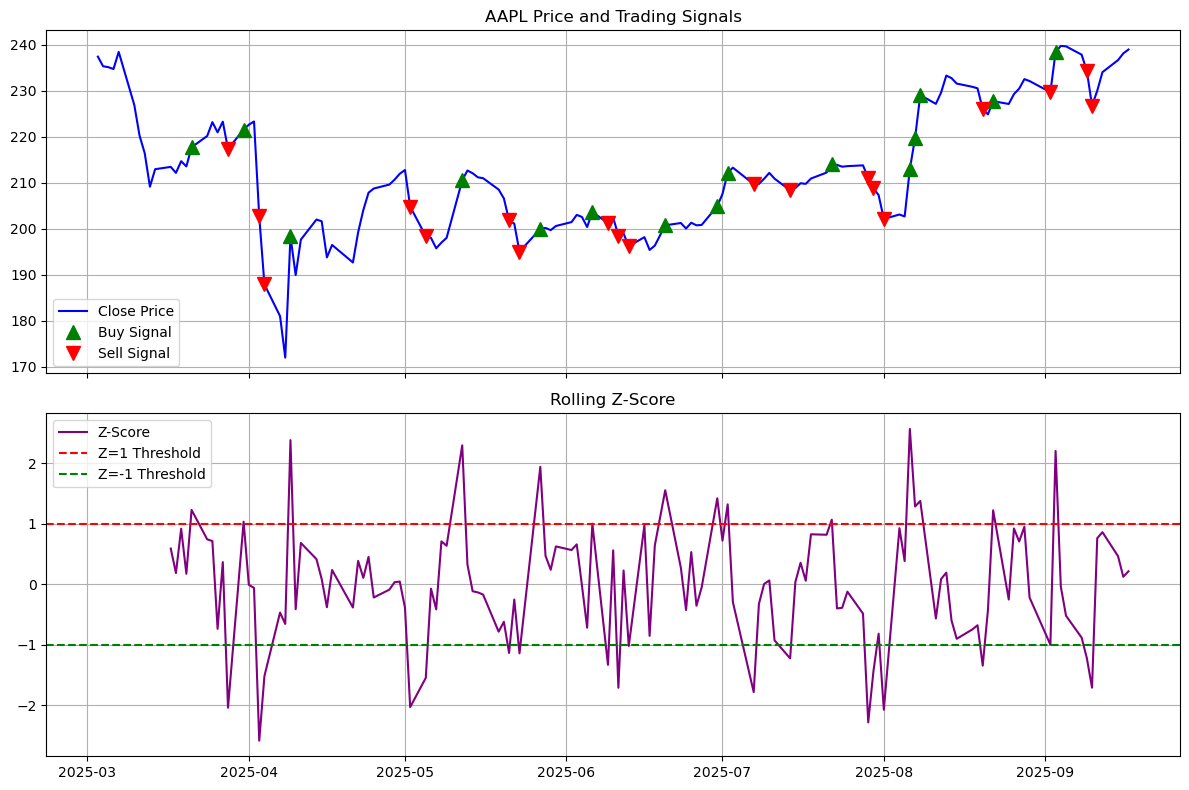

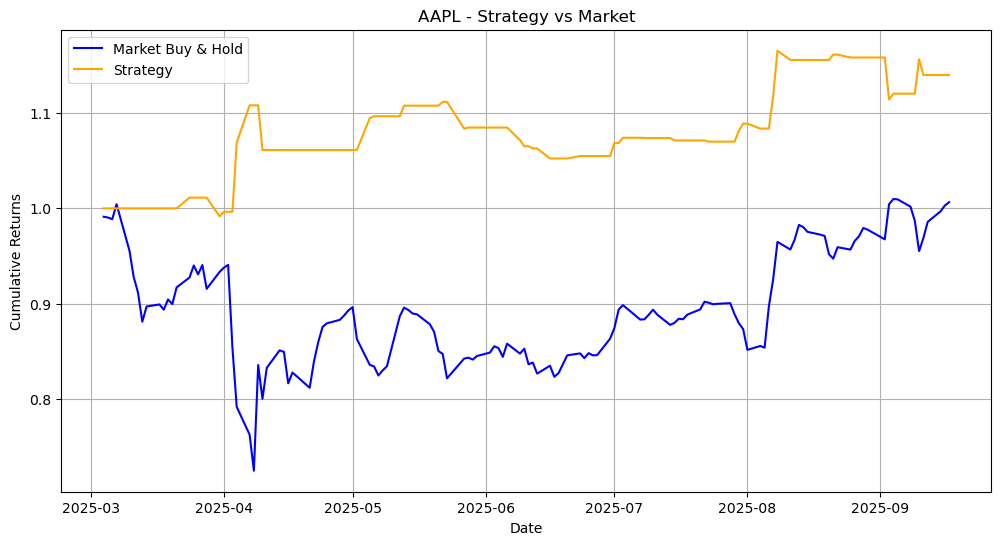

/tmp/ipykernel_132/1053244823.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed

AAPL - Final Buy & Hold Return: 1.01
AAPL - Final Strategy Return: 1.14


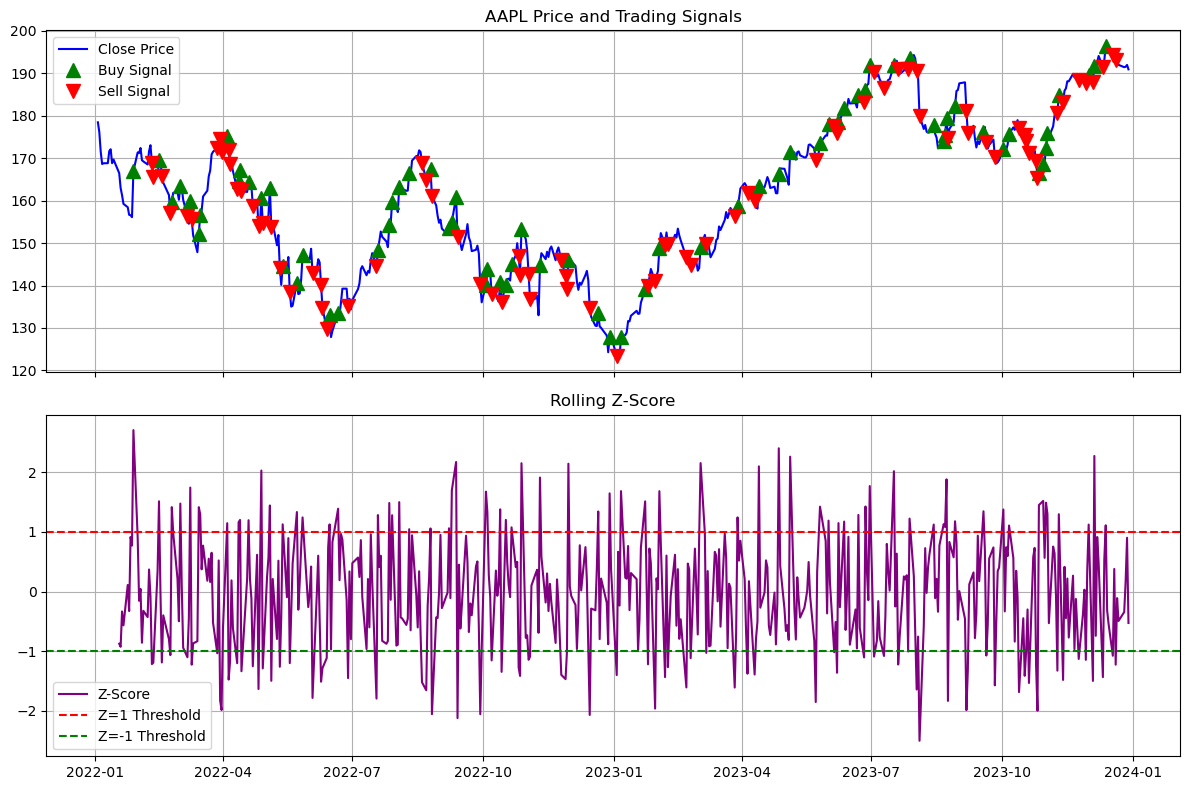

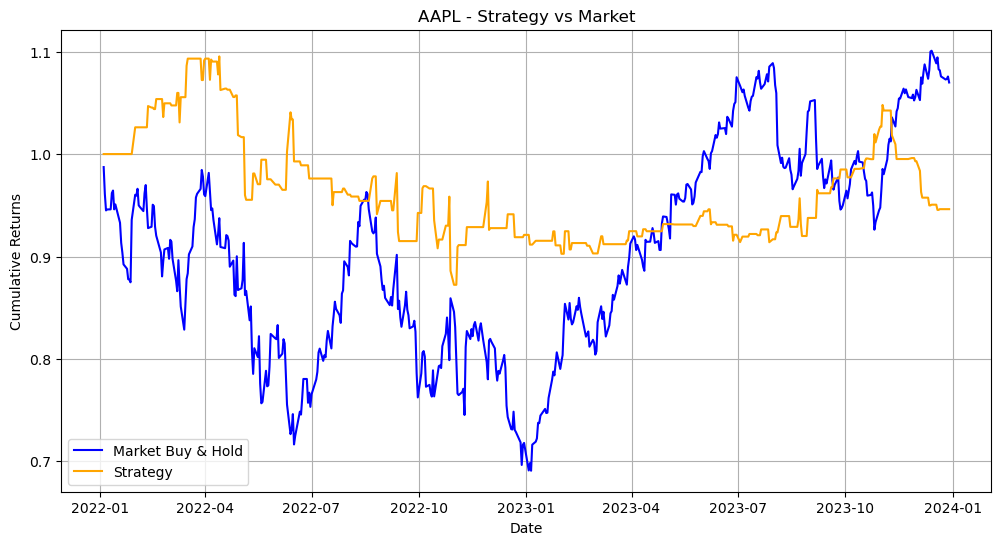

AAPL - Final Buy & Hold Return: 1.07
AAPL - Final Strategy Return: 0.95


In [129]:
apple_df = run_analysis("AAPL", start="2025-03-01", end="2025-09-18")
# analysis for Apple from 2022 to 2024
apple_df = run_analysis("AAPL", start="2022-01-01", end="2024-01-01")